In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import pickle
import helper_functions_06b as hf

In [2]:
DATE = ['20230302']#, '20230303']
SESSION = ['SM_Lek1']#, 'SE_Lek1']
DRONE = ['P1D1']#, 'P1D2', 'P2D3', 'P2D4', 'P3D5', 'P3D6']

tracking_directory = '/Volumes/EAS_shared/blackbuck/working/processed/TerritoryDetection2023'

In [3]:
# Thresholds for translation, rotation, and scale
thresholds = {
    'T_translation': 50,  # e.g., 30 pixels
    'T_rotation': 20,     # e.g., 20 degrees
    'T_scale': 0.1         # e.g., 10% change
}

In [6]:
for date in DATE:
    for session in SESSION:
        for drone in DRONE:
            internal_path = tracking_directory + '/' + date + '/' + session + '/' + drone
            files = glob.glob(internal_path + '/' + date + '_' + session + '_' + drone + '*_tracked.csv')
            
            for file in files:
                df = pd.read_csv(file)
                
                df['x'] = df['bb_left'] + df['bb_width']/2
                df['y'] = df['bb_top'] + df['bb_height']/2
                df['idx'] = df['track_id']

                df = df.loc[:,['frame', 'x', 'y', 'idx']]

### Import tracking data

In [4]:
tracking_dir = '/Volumes/EAS_shared/blackbuck/working/processed/TerritoryDetection2023/'
tracking_file = '20230310_SE_Lek1_P1D1_DJI_0190'

In [5]:
df = pd.read_csv(tracking_dir + '20230310/SE_Lek1/P1D1/' + tracking_file + '_YOLO_tracked.csv')
df['x'] = df['bb_left'] + df['bb_width']/2
df['y'] = df['bb_top'] + df['bb_height']/2
df['idx'] = df['track_id']

df = df.loc[:,['frame', 'x', 'y', 'idx']]
df.head()

,frame,x,y,idx
0,0,3231.399,58.680,43424
1,0,1596.498,174.696,43425
2,0,3602.919,276.867,43426
3,0,2578.536,318.834,43427
4,0,1220.571,437.763,43428


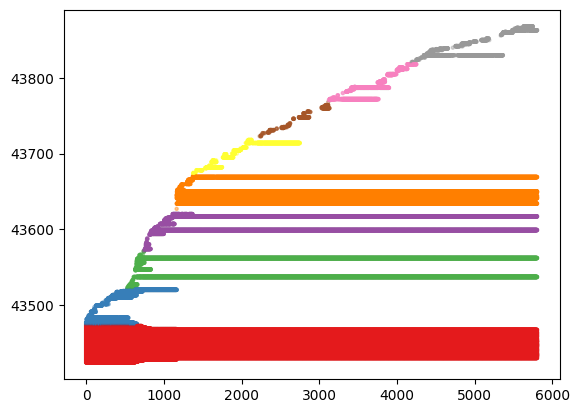

In [6]:
plt.scatter(df['frame'], df['idx'], c=df['idx'], cmap='Set1', s=5, alpha=0.4)

### Identify anchor frames and register other frames to their anchors

In [7]:
# Step 1: Identify anchor frames
anchor_frames = hf.identify_anchor_frames(df, thresholds)

# Step 2: Find the best anchor for each frame
df = hf.find_best_anchor_for_each_frame(df, anchor_frames, thresholds)

# Step 3: Apply homography using the best anchor for each frame
df, homography_matrices, rms_errors = hf.apply_homography_to_best_anchor(df)

df.to_csv('./io/' + tracking_file + '_Anchored.csv', index=False, mode='w')
with open('./io/homography_matrices.pkl', 'wb') as f:
    pickle.dump(homography_matrices, f)
    
df.head()

Initial identification of anchors takes  38.453776836395264
Finding the best anchors takes  3430.6708838939667
Applying homography to the best anchors takes  191.75993514060974


,frame,x,y,idx,best_anchor_frame,transformed_x,transformed_y
0,0,3231.399,58.680,43424,0.0,3231.399,58.680
1,0,1596.498,174.696,43425,0.0,1596.498,174.696
2,0,3602.919,276.867,43426,0.0,3602.919,276.867
3,0,2578.536,318.834,43427,0.0,2578.536,318.834
4,0,1220.571,437.763,43428,0.0,1220.571,437.763


t = 20; anchor_frames = 140; Finding the best anchors takes  5120.094700098038

t = 25; anchor_frames = 113; Finding the best anchors takes  4140.320204734802

t = 30; anchor_frames = 94; Finding the best anchors takes  3514.9457750320435

t = 40; anchor_frames = 69; Finding the best anchors takes  2565.164268016815

t = 50; anchor_frames = 53; Finding the best anchors takes  1995.120824098587

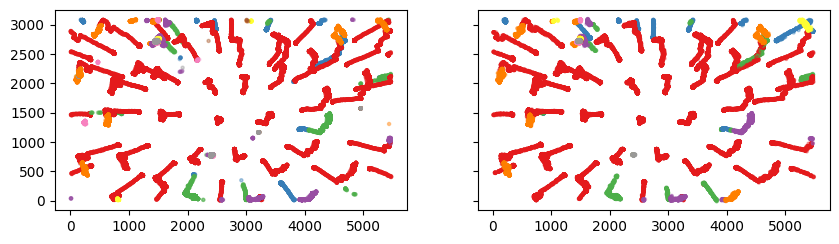

In [8]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(10,5), sharey=True)

ax1.scatter(df['x'], df['y'], c=df['idx'], cmap='Set1', s=5, alpha=0.4)
ax1.set_aspect('equal')

ax2.scatter(df['transformed_x'], df['transformed_y'], c=df['idx'], cmap='Set1', s=5, alpha=0.4)
ax2.set_aspect('equal')

plt.show()

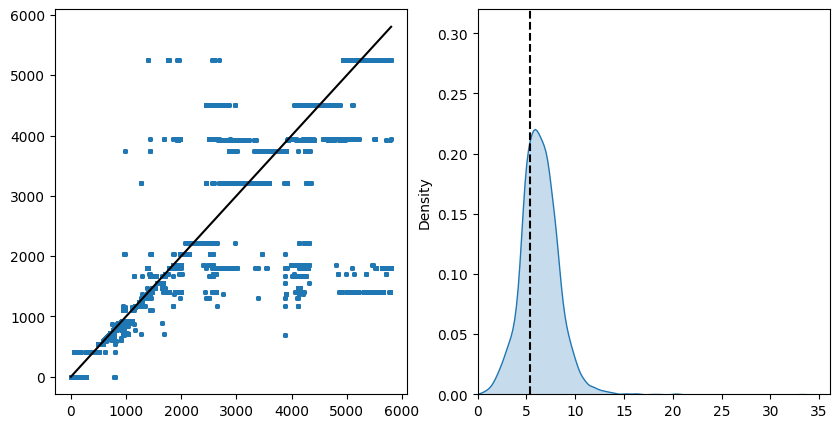

In [9]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.scatter(df['frame'], df['best_anchor_frame'], s=5)
ax1.plot(np.linspace(0,df['frame'].max()), np.linspace(0,df['frame'].max()), c='black')

sns.kdeplot(rms_errors, fill=True, ax=ax2)
ax2.vlines(5.4,0,0.32,color='black',linestyles='dashed')
ax2.set_xlim(0,)
ax2.set_ylim(0,0.32)

plt.show()